# <center>A Classical Policy Gradient Agent</center>

In [1]:
import time, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import numpy as np
from keras import Input, layers, Model
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import gym

In [2]:
from utilities import train_agent, render, animation
from rl_algorithms import Reinforce

<center>Create Gym Environment</center>

In [3]:
env = gym.make("CartPole-v1")

<center>Define Model Architecture</center>

In [4]:
num_layers = 7

inputs = Input(shape=env.observation_space.shape[0], dtype=tf.dtypes.float32, name='Input')

dense = layers.Dense(12, activation='linear')(inputs)

policy_logits = layers.Dense(2, activation='linear', name="Logits")(dense)
policy_probabilities = layers.Softmax(name="Probabilities")(policy_logits)

policy = Model(inputs=[inputs], outputs=[policy_probabilities], name="Policy")

policy.summary()

Model: "Policy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 12)                60        
                                                                 
 Logits (Dense)              (None, 2)                 26        
                                                                 
 Probabilities (Softmax)     (None, 2)                 0         
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


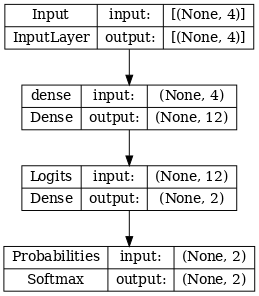

In [5]:
tf.keras.utils.plot_model(policy, to_file="/tmp/model.png", show_shapes=True, dpi=70)

<center>Train Model</center>

In [6]:
%%time

agent = Reinforce(policy, learning_rate=0.01, discount_factor=0.99)

def shaped_reward(reward, observation):
    position, pos_vel, angle, angle_vel = observation
    #return (1 - tf.abs(angle))
    return 1.0 / (1 + 0.5*position**2)

state_bounds = np.array([2.4, 2.5, 0.21, 2.5]).astype(np.float32)
    
total_rewards, episode_lengths, success = train_agent(env, agent, shaped_reward,
                                                    500, 5000, state_bounds,
                                                    (475, 100), True)

Episode: 270, Steps: 500, Average Episode Length: 472.9
Solved at Episode 271, Average Episode Length: 476.3

CPU times: user 2min 8s, sys: 16.7 s, total: 2min 24s
Wall time: 2min 18s


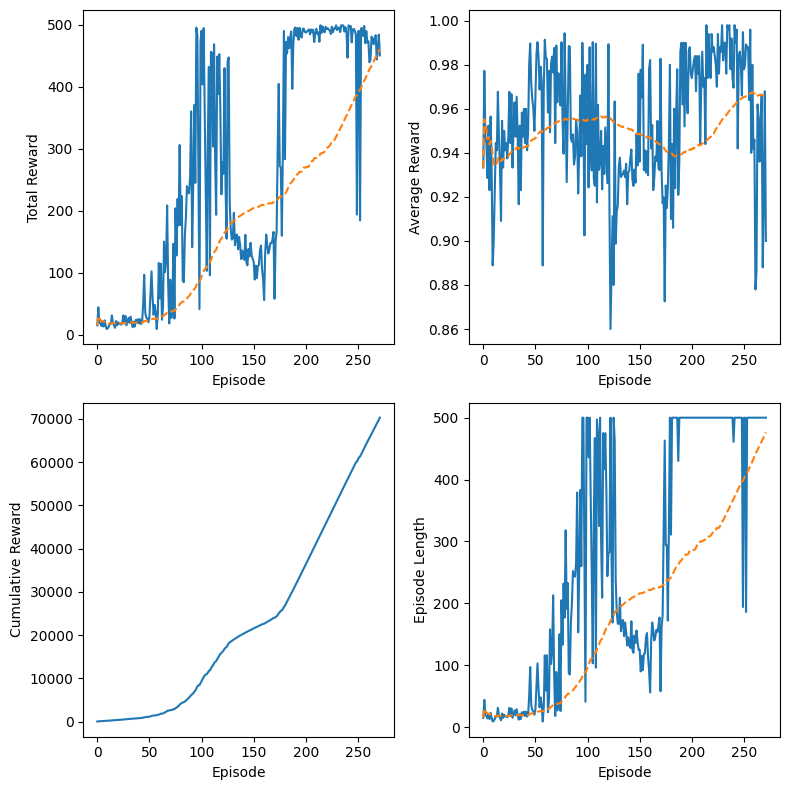

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

def running_average(data, window):
    running_avg = []
    for i in range(len(data)):
        start_index = i + 1 - min(i + 1, window)
        avg = np.mean(data[start_index:i + 1])
        running_avg.append(avg)
    return np.array(running_avg)

labels = ['Total Reward', 'Average Reward', 'Cumulative Reward', 'Episode Length']
data = [total_rewards, np.array(total_rewards) / episode_lengths, np.cumsum(total_rewards), episode_lengths]

for ax, label, data in zip(axes.flat, labels, data):
    ax.set_xlabel('Episode')
    ax.set_ylabel(label)
    ax.plot(data)
    if label != 'Cumulative Reward': ax.plot(running_average(data, 100), '--')

fig.tight_layout()
plt.show()

In [8]:
from pyvirtualdisplay import *
vdisp = Display(visible=0, size=(500, 500)).start()

def action_fn(env, observation):
    observation = observation / state_bounds
    return agent.act(observation).numpy()

env = gym.make('CartPole-v1')
frames = render(env, action_fn, 500)
env.close()

HTML(animation(frames, len(frames)/24e-3).to_html5_video())

In [9]:
if success:
    timestamp = time.strftime("%Y.%m.%d-%H.%M")
    dirname = f'./Results/PG-{timestamp}'
    os.mkdir(dirname)
    print(timestamp)
    
    results = {"Total Reward":total_rewards, "Episode Length": episode_lengths}
    np.save(f'{dirname}/results.npy', results)
    agent.policy.save(f'{dirname}/policy.keras')

2024.08.16-09.03
